<a href="https://colab.research.google.com/github/vietanhdev/tflite-micro-esp-examples/blob/master/Image_Classification_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification training for TFLite Micro

This notebook trains an image classification on bottle dataset - classifying images as bottle or not bottle. We also provided conversion code for TFLite, and TFLite for Microcontrollers. You can easily adapt this code for other datasets.

Brought you by [vietanhdev](https://github.com/vietanhdev).
- See more projects in my Github: [github.com/vietanhdev](https://github.com/vietanhdev)
- [Donate for by open source projects](https://www.patreon.com/vietanhdev).


In [1]:
# Check GPU.
# If you are using Colab Pro, GPU should be Tesla P100 or V100 or better
!nvidia-smi

Sat Nov 27 14:15:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import Tensorflow and check version
# All below code was tested with Tensorflow 2.7.0
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
# Import other packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import glob
import time
import cv2
import os

**Hyperparams:**

In [4]:
num_epochs = 30
learning_rate = 0.001
batch_size = 64

## I. Data preparation

We prepared an image classification dataset containing 2 classes: **bottles** (bottle/can) and **not_bottles** (other objects). This dataset is made from ImageNet by downloading images from specific classes using [this script](https://github.com/mf1024/ImageNet-Datasets-Downloader).

After following block, dataset will be downloaded and extracted to `/content/data_raw/bottles` and `/content/data_raw/not_bottles` folders.

### Download the data

In [5]:
!mkdir /content/data_raw
%cd /content/data_raw
# Download the dataset
!gdown  https://drive.google.com/uc?id=10z0odJo94buDdnPy3DEGbxA_hgAdSaBW
# Extract
!unzip -qo bottle_classification_data_v2.zip

/content/data_raw
Downloading...
From: https://drive.google.com/uc?id=10z0odJo94buDdnPy3DEGbxA_hgAdSaBW
To: /content/data_raw/bottle_classification_data_v2.zip
100% 814M/814M [00:03<00:00, 224MB/s]


In [6]:
# Get all images
%cd /content/data_raw
all_img_paths = list(paths.list_images("."))
print(all_img_paths[:10])

/content/data_raw
['./not_bottles/dormitory/349325747_6bcb182d23.jpg', './not_bottles/dormitory/226439595_9f7281435f.jpg', './not_bottles/dormitory/109187978_47c448edf1.jpg', './not_bottles/dormitory/2355108489_9447a71bd4.jpg', './not_bottles/dormitory/2303867423_3eaa69910b.jpg', './not_bottles/dormitory/466208991_12a21164c7.jpg', './not_bottles/dormitory/234994657_289a4bc33f.jpg', './not_bottles/dormitory/2400864791_c7a0dc1349.jpg', './not_bottles/dormitory/238055925_751de41fbf.jpg', './not_bottles/dormitory/2346099238_69b71a4ca5.jpg']


### Shuffle and visualize

In [7]:
# Shuffle the image paths and preview
np.random.seed(0)
random.shuffle(all_img_paths)
print(all_img_paths[:5])

['./not_bottles/home room/307320107_47776f6961.jpg', './bottles/bottle/2258189301_92005399e3.jpg', './bottles/catsup bottle/2871011405_47b3148f88.jpg', './bottles/wine bottle/390499883_093a36a430.jpg', './not_bottles/hotel/2292874251_d602bb680d.jpg']


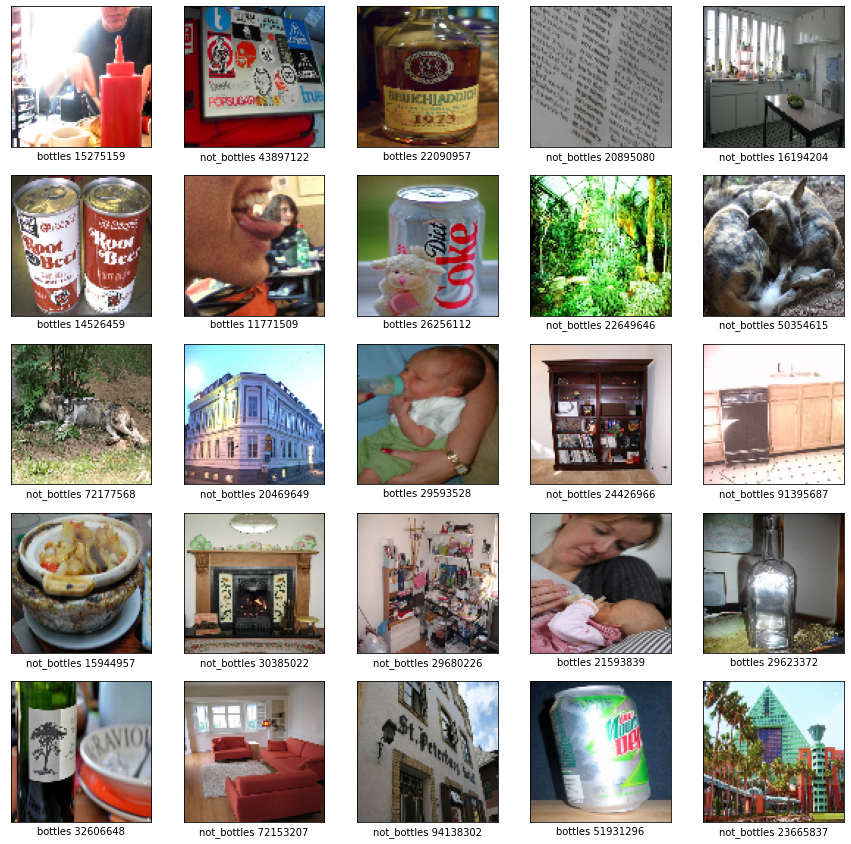

In [8]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(all_img_paths)
    image = plt.imread(image_path)
    image = cv2.resize(image, (96, 96))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label + " " + os.path.basename(image_path)[:8])
plt.show()

### Split the dataset
 
For simplicity, we split the data into only two subsets: training set (85%) and validation set (15%). You can also hold out some images for the test set by modifying following blocks.

After spliting, our dataset structure should be like following:

```
/content
    + /train
        + /bottles
        + /not_bottles
    + /val
        + /bottles
        + /not_bottles
```


In [9]:
!rm -rf /content/data/

In [10]:
val_ratio = 0.15
train_dir = "/content/data/train"
val_dir = "/content/data/val"

In [11]:
val_imgs = int(len(all_img_paths) * val_ratio)
train_imgs = len(all_img_paths) - val_imgs
train_img_paths = all_img_paths[:train_imgs]
test_img_paths = all_img_paths[train_imgs:]

In [12]:
# Function for copying images into subset folder
def copy_images(img_paths, output_dir):
	for imagePath in img_paths:
		# extract the label from the current image path
		label = imagePath.split("/")[1]

		# check if a directory for the label exists, if not, create it
		imageDir = os.path.join(output_dir, label)
		if not os.path.exists(imageDir):
			os.makedirs(imageDir)

		# copy the current image to the respective folder
		shutil.copy2(imagePath, imageDir)

In [13]:
copy_images(train_img_paths, train_dir)
copy_images(test_img_paths, val_dir)

### Prepare data generator

We will use Keras `ImageDataGenerator` to feed data for training and validation. Images will be loaded automatically by the generators, transformed with augmentation methods, and resized to the same size of model input (96x96).

In [14]:
# Switch to /content/data
%cd /content/data

/content/data


In [15]:
# Setup data generators
train_aug = ImageDataGenerator(rescale=1/255.,
								horizontal_flip=True,
								vertical_flip=True,
								brightness_range=[0.7, 1.2],
								zoom_range=0.3,
								rotation_range=30,
								width_shift_range=0.3,
								height_shift_range=0.3,
								channel_shift_range=0.5)

val_aug = ImageDataGenerator(rescale=1/255.,
                             horizontal_flip=True,
							 vertical_flip=True,)

print("Training set")
train_gen = train_aug.flow_from_directory(train_dir,
    class_mode="categorical",
    target_size=(96, 96),
	color_mode="rgb",
	shuffle=True,
	batch_size=batch_size
)

print("Validation set")
val_gen = train_aug.flow_from_directory(val_dir,
    class_mode="categorical",
    target_size=(96, 96),
	color_mode="rgb",
	shuffle=False,
	batch_size=batch_size
)
num_classes = len(train_gen.class_indices.keys())
print("Set number of classes to {}".format(num_classes))

Training set
Found 11954 images belonging to 2 classes.
Validation set
Found 2134 images belonging to 2 classes.
Set number of classes to 2


In [16]:
# Get the class labels and export to labels.txt
print(train_gen.class_indices)
labels = '\n'.join(sorted(train_gen.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

{'bottles': 0, 'not_bottles': 1}


In [17]:
# Save number of training and validation samples to use later
num_train_samples = len(list(paths.list_images("train")))
num_val_samples = len(list(paths.list_images("val")))
print("Train: {} images, Val: {} images".format(num_train_samples, num_val_samples))

Train: 11954 images, Val: 2134 images


## II. Training

In this section, we build and train an image classification model based on prepared data. The function `build_model` below helps us to prepare the model. We use [MobileNet](https://arxiv.org/abs/1704.04861) as the backbone for feature extraction, then attach a `GlobalAveragePooling2D` layers and some more fully connected layers for classification. `Dropout` layers are added to prevent overfitting.

There are multiple variants of MobileNet now (v2, v3). However, we use the first MobileNet version because it requires least memory. It's important because we are training a model for microcontrollers.


In [18]:
# Switch to /content
%cd /content

/content


In [19]:
def build_model():
    extractor = MobileNet(weights="imagenet", alpha=0.25, include_top=False, input_shape=(96, 96, 3))
    extractor.trainable = True
    class_head = extractor.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(64, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(num_classes, activation="softmax")(class_head)
    classifier = Model(inputs=extractor.input, outputs=class_head)
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(learning_rate),
                          metrics=["accuracy"])
    return classifier

In [20]:
# Build model
classification_model = build_model()

# Setup a callback to save the best model
best_model_path = "best_model_checkpoint.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start = time.time()
history = classification_model.fit(train_gen,
    steps_per_epoch=num_train_samples // batch_size,
    validation_data=val_gen,
    validation_steps=num_val_samples // batch_size,
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback]
)
print("Total training time: ", time.time()-start)

# Load the best model weights
classification_model.load_weights(best_model_path)

2121728/2108140 [==============================] - 0s 0us/step
Epoch 1/30
186/186 [==============================] - 91s 434ms/step - loss: 0.8383 - accuracy: 0.6295 - val_loss: 0.6373 - val_accuracy: 0.6170
Epoch 2/30
186/186 [==============================] - 80s 430ms/step - loss: 0.5775 - accuracy: 0.7062 - val_loss: 0.5237 - val_accuracy: 0.7320
Epoch 3/30
186/186 [==============================] - 80s 433ms/step - loss: 0.5286 - accuracy: 0.7434 - val_loss: 0.5222 - val_accuracy: 0.7396
Epoch 4/30
186/186 [==============================] - 80s 430ms/step - loss: 0.5064 - accuracy: 0.7602 - val_loss: 0.4797 - val_accuracy: 0.7808
Epoch 5/30
186/186 [==============================] - 80s 430ms/step - loss: 0.4881 - accuracy: 0.7693 - val_loss: 0.4835 - val_accuracy: 0.7666
Epoch 6/30
186/186 [==============================] - 80s 432ms/step - loss: 0.4745 - accuracy: 0.7816 - val_loss: 0.5274 - val_accuracy: 0.7287
Epoch 7/30
186/186 [==============================] - 80s 430ms/ste

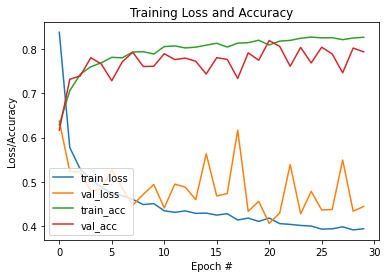

In [21]:
# Plot training graph
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [22]:
eval_result = classification_model.evaluate(val_gen)
val_accuracy = eval_result[1]
print("Model accuracy on validation set: {}".format(val_accuracy))

34/34 [==============================] - 12s 350ms/step - loss: 0.4154 - accuracy: 0.8116
Model accuracy on validation set: 0.811621367931366


## III. Convert model to TFLite

[TFLite](https://www.tensorflow.org/lite) is a framework from Google for model inference on mobile devices and embedded hardware. Google also introduced [TFLite Micro](https://www.tensorflow.org/lite/microcontrollers/get_started_low_level) in 2021, providing us a powerful framework for running AI models on microcontrollers. After training our model with Tensorflow, we need some more steps to convert our model for using with TFLite.

The trained model uses `float` data types for almost of its operations, that's not friendly with resource constrainted devices. We will quantize the model to work with `int8` only. This step requires a representative dataset to calibrate the operations to reduce the loss of accuracy.

### Prepare calibration dataset

In [23]:
# Number of training images used in quantization
num_quant_images = 500

In [24]:
# Extract the image paths from the train set, shuffle them
image_paths = list(paths.list_images("/content/data/train"))
random.shuffle(image_paths)
image_paths = image_paths[:num_quant_images]

# An empty list as a placeholder for the dataset
rep_ds = []

# Iterate over the image paths
for image in tqdm(image_paths):
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = cv2.imread(image)
    image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_BGR2RGB)
    image_pixels = cv2.resize(image_pixels, (96, 96)).astype("float32")
    image_pixels = np.expand_dims(image_pixels, 0)
    image_pixels = image_pixels / 255.
    
    # Append to the list
    rep_ds.append(image_pixels)

100%|██████████| 500/500 [00:01<00:00, 300.60it/s]


In [25]:
# Convert to TensorFlow dataset
rep_ds = np.array(rep_ds)
rep_ds = tf.data.Dataset.from_tensor_slices((rep_ds))

In [26]:
# Creating a representative dataset for int quantization
def representative_dataset():
    for image in rep_ds.take(num_quant_images):
        yield [image]

### Convert the model

In [27]:
# TF Lite conversion 
# Specify the representative dataset for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(classification_model) 
converter.optimizations = [tf.lite.Optimize.DEFAULT] 
converter.representative_dataset = representative_dataset

# We are going for full INT8 quantization
# inference_input_type and inference_output_type are only supported from TF 2.3.0
# https://github.com/tensorflow/tflite-micro/issues/280
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmppwb_4w0m/assets


Let's compare the sizes of the both the models. 

In [28]:
# Unoptimized (SavedModel format)
classification_model.save("classification_model_no_op")
# Check size
!du --all -h classification_model_no_op

INFO:tensorflow:Assets written to: classification_model_no_op/assets


INFO:tensorflow:Assets written to: classification_model_no_op/assets


1.9M	classification_model_no_op/saved_model.pb
4.0K	classification_model_no_op/assets
24K	classification_model_no_op/variables/variables.index
2.8M	classification_model_no_op/variables/variables.data-00000-of-00001
2.8M	classification_model_no_op/variables
188K	classification_model_no_op/keras_metadata.pb
4.8M	classification_model_no_op


In [29]:
# Serialize the TFLite model and check it's size
f = open("classification_model.tflite", "wb")
f.write(tflite_model)
f.close()

!du -h classification_model.tflite

316K	classification_model.tflite


### Evaluate quantized TFLite model

See the reduction in model's size! Let's now evaluate this model on the validation dataset using the code listsings from [here](https://www.tensorflow.org/lite/performance/post_training_integer_quant#evaluate_the_models). Let's first load the TF Lite model into an interpreter. 

In [30]:
# Load the model into interpreters
interpreter_quant = tf.lite.Interpreter(model_content=tflite_model)
interpreter_quant.allocate_tensors()
input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

In [31]:
# Prepare validation set
%cd /content/data/
image_paths = list(paths.list_images("val"))

# Empty labels for storing images and labels
val_images = []
val_labels = []

input_details = interpreter_quant.get_input_details()[0]

# Iterate over the image paths
for image in tqdm(image_paths):
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = cv2.imread(image)
    image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_BGR2RGB)
    image_pixels = cv2.resize(image_pixels, (96, 96)).astype("float32")

    # Check if the input type is quantized, then rescale input data to uint8
    input_scale, input_zero_point = input_details["quantization"]
    image_pixels = image_pixels / 255.0 / input_scale + input_zero_point
    image_pixels = np.expand_dims(image_pixels, axis=0).astype(input_details["dtype"])

    # Extract the label
    label = image.split("/")[1]
    
    # Append to the list
    val_images.append(image_pixels)
    val_labels.append(label)

# Create NumPy array
val_images = np.array(val_images)

/content/data


100%|██████████| 2134/2134 [00:07<00:00, 295.63it/s]


In [32]:
labels = ["bottles", "not_bottles"]

# A helper function to evaluate the TF Lite model using "test" dataset.
# Comes from: https://www.tensorflow.org/lite/performance/post_training_integer_quant
def evaluate_model(interpreter):
  accurate_count = 0
  
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  predictions = []
  for val_image, val_label in zip(val_images, val_labels):
    interpreter.set_tensor(input_index, val_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    probability = interpreter.get_tensor(output_index)
    pred_id = np.argmax(probability[0])

    predictions.append(pred_id)
    
    # Compare prediction results with ground truth labels to calculate accuracy.
    if labels[pred_id] == val_label:
      accurate_count += 1
  
  accuracy = accurate_count * 1.0 / len(predictions)

  return accuracy

In [33]:
# Check accuracy after quantization
print("Original model accuracy: {}".format(val_accuracy))
print("Quantized model accuracy: {}".format(evaluate_model(interpreter_quant)))

Original model accuracy: 0.811621367931366
Quantized model accuracy: 0.8369259606373008


### Convert for using with Microcontrollers

An efficient and convenient way to store models for microcontroller is to convert them into memory buffer in the source code. `xxd` tool can be used for this purpose.

In [37]:
%cd /content
# Install xxd if it is not available
! apt-get -qq install xxd
# Save the file as a C source file
! xxd -i /content/classification_model.tflite > classification_model_data.h

/content


## References

- https://www.tensorflow.org/lite/tutorials/model_maker_image_classification#step_4_export_to_tensorflow_lite_model
- https://www.tensorflow.org/lite/performance/post_training_quantization